In [23]:
import pandas as pd
data=pd.read_csv('../raw_data/Tool_Info.csv')
data['age']=2019-data['year_of_pub']+1
data['citation_per_year']=data['num_citations']/data['age']
data.loc[data.loc[:,'aligner'] == 'HISAT2', 'citation_per_year'] = 95

# Creating new columns that combine rarer types
data.loc[data.loc[:,'indexing'] == 'hashing', 'index'] = 'Hashing'
data.loc[data.loc[:,'indexing'] == 'BWT-FM', 'index'] = 'BWT-FM'
data.loc[data.loc[:,'indexing'] == 'BWT-FM + hashing', 'index'] = 'BWT-FM & Hashing'
data.loc[data.loc[:,'indexing'] == 'suffix array', 'index'] = 'Other Suffix'
data.loc[data.loc[:,'indexing'] == 'BWT-ST', 'index'] = 'Other Suffix'
data.loc[data.loc[:,'indexing'] == 'suffix tree', 'index'] = 'Other Suffix'

data.loc[data.loc[:,'pairwise_alignment'] == 'SW', 'pairwise'] = 'Smith-Waterman'
data.loc[data.loc[:,'pairwise_alignment'] == 'HD', 'pairwise'] = 'Hamming Distance'
data.loc[data.loc[:,'pairwise_alignment'] == 'NW', 'pairwise'] = 'Needleman-Wunsch'
data.loc[data.loc[:,'pairwise_alignment'] == 'Non-DP Heuristic', 'pairwise'] = 'Non-DP Heuristic'
data.loc[data.loc[:,'pairwise_alignment'] == 'SW & NW', 'pairwise'] = 'Multiple Methods'
data.loc[data.loc[:,'pairwise_alignment'] == 'SW & Semi-Global', 'pairwise'] = 'Multiple Methods'
data.loc[data.loc[:,'pairwise_alignment'] == 'Rabin-Karp Algorithm', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Landau-Vishkin', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Sparse DP', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Banded Myers Bit Vector', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Myers Bit-Vector', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Semi-Global', 'pairwise'] = 'Other DP'

data.loc[data.loc[:,'fix_length_seed'] == 'Y', 'seeds_fixed'] = 'Yes'
data.loc[data.loc[:,'fix_length_seed'] == 'N', 'seeds_fixed'] = 'No'

data.loc[data.loc[:,'seed_chaining'] == 'Y', 'seeds_chained'] = 'Yes'
data.loc[data.loc[:,'seed_chaining'] == 'N', 'seeds_chained'] = 'No'

data.loc[data.loc[:,'spaced_seed'] == 'Y', 'seeds_spaced'] = 'Yes'
data.loc[data.loc[:,'spaced_seed'] == 'N', 'seeds_spaced'] = 'No'

data_year = pd.DataFrame(data.loc[:,['year_of_pub', 'aligner', 'application', 'index', 
                        'pairwise', 'seeds_fixed', 'seeds_spaced', 'seeds_chained']])
data_year.loc[:,'aligner_lower'] = data_year.loc[:,'aligner'].str.lower()

data.head()

,ID,aligner,url,year_of_pub,application,indexing,fix_length_seed,spaced_seed,seed_chaining,pairwise_alignment,...,num_citations,wrapper,wrapper_of,age,citation_per_year,index,pairwise,seeds_fixed,seeds_chained,seeds_spaced
0,104,BatMeth2,https://github.com/GuoliangLi-HZAU/BatMeth2/,2019,BS-Seq,BWT-FM,Y,N,Y,SW & NW,...,2,N,NaN,1,2.000000,BWT-FM,Multiple Methods,Yes,Yes,No
1,63,BS-Seeker2,https://github.com/BSSeeker/BSseeker2,2013,BS-Seq,BWT-FM,Y,N,Y,SW & NW,...,173,Y,Bowtie2,7,24.714286,BWT-FM,Multiple Methods,Yes,Yes,No
2,54,BRAT-BW,http://compbio.cs.ucr.edu/brat/,2012,BS-Seq,BWT-FM,N,N,N,HD,...,70,N,NaN,8,8.750000,BWT-FM,Hamming Distance,No,No,No
3,43,Bismark,https://github.com/FelixKrueger/Bismark,2011,BS-Seq,BWT-FM,Y,N,Y,SW & NW,...,1550,Y,Bowtie2 or HISAT2,9,172.222222,BWT-FM,Multiple Methods,Yes,Yes,No
4,32,BS-Seeker,https://github.com/BSSeeker/BSseeker2,2010,BS-Seq,BWT-FM,Y,N,N,HD,...,215,Y,Bowtie,10,21.500000,BWT-FM,Hamming Distance,Yes,No,No


In [24]:
rt = pd.read_csv('../raw_data/compare.tools.runtime.hours.csv')
mem = pd.read_csv('../raw_data/compare.tools.memory.csv')

In [25]:
rt.loc[:,'tools_lower'] = rt.loc[:,'Tools'].str.lower()
rtyear = pd.merge(rt, data_year, left_on='tools_lower', right_on='aligner_lower', how='inner')
rtyear.loc[:,'average_runtime'] = rtyear.iloc[:,1:11].mean(axis=1)
rtyear.loc[:,'std_dev'] = rtyear.iloc[:,1:11].std(axis=1)

# Imputing the one missing value
rtyear.loc[3,'ERR162843'] = rtyear.loc[3,'average_runtime'] 

# Only compare tools with DNA application
rtyear = rtyear.loc[rtyear.loc[:,'application'] != 'RNA-Seq'].reset_index(drop=True)

# Bowtie2 can be run in global or local, our data was generated using Needleman-Wunsch (Global)
rtyear.loc[rtyear.loc[:,'Tools'] == 'Bowtie2','pairwise'] = 'Needleman-Wunsch'
rtyear.loc[rtyear.loc[:,'Tools'] == 'last','pairwise'] = 'Smith-Waterman'
rtyear_summ = rtyear.loc[:,['aligner', 'year_of_pub', 'average_runtime', 'std_dev', 'application', 
                            'index', 'pairwise', 'seeds_fixed', 'seeds_spaced', 'seeds_chained']]
rtyear_summ.sort_values(by=['year_of_pub'], inplace=True)
for i in range(0,11):
    if rtyear.loc[i,'year_of_pub'] < 2013:
        rtyear.loc[i,'year_split'] = 'Before 2013'  
    else:
        rtyear.loc[i,'year_split'] = '2013 and later'
rtyear_melt = pd.melt(rtyear, id_vars = ['aligner', 'year_split', 'application', 'index', 'pairwise'], 
        value_vars = ['ERR009309', 'ERR013127', 'ERR013138', 'ERR045708', 'ERR050158', 'ERR162843', 'ERR181410',
                     'ERR183377', 'SRR061640', 'SRR360549'], value_name = 'runtime')
rtyear.to_csv(path_or_buf='../summary_data/runtime_comparison_with_tool_info.csv')
rtyear_melt

,aligner,year_split,application,index,pairwise,variable,runtime
0,Bowtie2,Before 2013,DNA,BWT-FM,Needleman-Wunsch,ERR009309,2.364914
1,Bowtie,Before 2013,DNA,BWT-FM,Hamming Distance,ERR009309,3.358317
2,BWA,Before 2013,DNA,BWT-FM,Other DP,ERR009309,4.048227
3,GSNAP,Before 2013,DNA,Hashing,Non-DP Heuristic,ERR009309,18.782465
4,HISAT2,2013 and later,DNA,BWT-FM,Non-DP Heuristic,ERR009309,0.582257
5,LAST,Before 2013,DNA/BS-Seq/protein/RNA,Other Suffix,Smith-Waterman,ERR009309,10.140177
6,minimap2,2013 and later,DNA/RNA-Seq,Hashing,Needleman-Wunsch,ERR009309,0.955566
7,RMAP,Before 2013,DNA,Hashing,Hamming Distance,ERR009309,7.669205
8,SMALT,Before 2013,DNA,Hashing,Smith-Waterman,ERR009309,12.295481
9,SNAP,Before 2013,DNA,Hashing,Needleman-Wunsch,ERR009309,1.074248


In [26]:
mem.loc[:,'tools_lower'] = mem['Tools'].str.lower()
memyear = pd.merge(mem, data_year, left_on='tools_lower', right_on='aligner_lower', how='inner')
memyear.loc[:,'average_memory'] = memyear.iloc[:,1:11].mean(axis=1)
memyear = memyear.loc[memyear.loc[:,'application'] != 'RNA-Seq'].reset_index(drop=True)
memyear.loc[memyear.loc[:,'Tools'] == 'Bowtie2','pairwise'] = 'Needleman-Wunsch'
memyear.loc[memyear.loc[:,'Tools'] == 'last','pairwise'] = 'Smith-Waterman'

memyear_summ = memyear.loc[:,['aligner', 'year_of_pub', 'average_memory', 'application', 'index', 
                             'pairwise','seeds_fixed','seeds_spaced', 'seeds_chained',]]
memyear_summ.sort_values(by=['year_of_pub'], inplace=True)
for i in range(0,11):
    memyear.loc[i,'year_split'] = 'Before 2013' if memyear.loc[i,'year_of_pub'] < 2013 else '2013 and later'
    
memyear_melt = pd.melt(memyear, id_vars = ['aligner', 'year_split', 'application', 'index', 'pairwise'], 
        value_vars = ['ERR009309', 'ERR013127', 'ERR013138', 'ERR045708', 'ERR050158', 'ERR162843', 'ERR181410',
                     'ERR183377', 'SRR061640', 'SRR360549'], value_name = 'memory')
memyear.to_csv(path_or_buf='../summary_data/memory_comparison_with_tool_info.csv')
memyear_summ

,aligner,year_of_pub,average_memory,application,index,pairwise,seeds_fixed,seeds_spaced,seeds_chained
7,RMAP,2008,9.5320,DNA,Hashing,Hamming Distance,Yes,No,No
1,Bowtie,2009,3.1940,DNA,BWT-FM,Hamming Distance,Yes,No,No
2,BWA,2009,5.7110,DNA,BWT-FM,Other DP,No,No,No
3,GSNAP,2010,28.8536,DNA,Hashing,Non-DP Heuristic,Yes,No,Yes
8,SMALT,2010,3.6766,DNA,Hashing,Smith-Waterman,Yes,No,Yes
5,LAST,2011,15.3589,DNA/BS-Seq/protein/RNA,Other Suffix,Smith-Waterman,No,Yes,No
9,SNAP,2011,36.1000,DNA,Hashing,Needleman-Wunsch,Yes,No,No
0,Bowtie2,2012,3.5799,DNA,BWT-FM,Needleman-Wunsch,Yes,No,Yes
10,Subread,2013,8.1088,DNA/RNA-Seq,Hashing,Smith-Waterman,Yes,Yes,Yes
6,minimap2,2018,12.4488,DNA/RNA-Seq,Hashing,Needleman-Wunsch,Yes,No,Yes


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as scp
import numpy as np

tool_clrs = ['teal', 'purple', 'palegreen', 'deepskyblue', 'magenta', 'maroon', 'khaki', 
        'darkorange', 'limegreen', 'turquoise', 'blue']

index_clrs = ['darkorange', 'mediumorchid', 'cornflowerblue', 'navy']

local_clrs = ['orange', 'deepskyblue', 'chocolate', 'gold', 'royalblue', 'lightseagreen']

order_by_year = ["RMAP", "Bowtie", "BWA", "GSNAP", "SMALT", "LAST", "SNAP", "Bowtie2", "Subread", 
                 "HISAT2", "minimap2"]

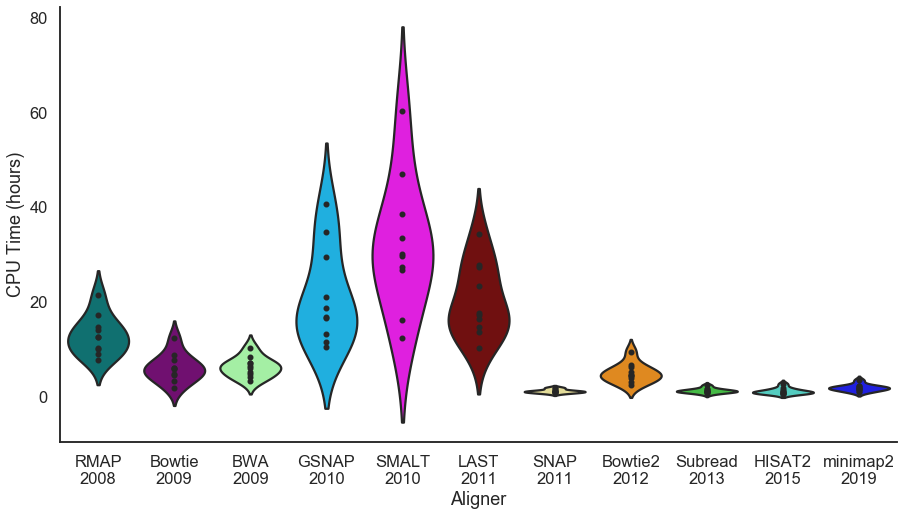

In [28]:
plt.figure(figsize=(15,8))
my_order = rtyear_melt.groupby(by='aligner')[["runtime"]].median()
my_order = my_order.sort_values(by='runtime').index

sns.set_style('white')
sns.set_context('talk')
ax = sns.violinplot(data = rtyear_melt, x = 'aligner', y = 'runtime', scale='width', palette=tool_clrs,# color = "grey"
                   order = order_by_year, inner='points', alpha=.75)
ax.set(xlabel = 'Aligner', ylabel = 'CPU Time (hours)')
ax.set_xticklabels(#rotation=40, ha="right", 
                   labels=["RMAP\n2008", "Bowtie\n2009", "BWA\n2009", "GSNAP\n2010", "SMALT\n2010", "LAST\n2011", 
                           "SNAP\n2011", "Bowtie2\n2012", "Subread\n2013", "HISAT2\n2015", "minimap2\n2019"])
sns.despine()
#plt.show()
plt.savefig('../figures/Figure3_a_0.png')
plt.savefig('../figures/Figure3_a_0.pdf')

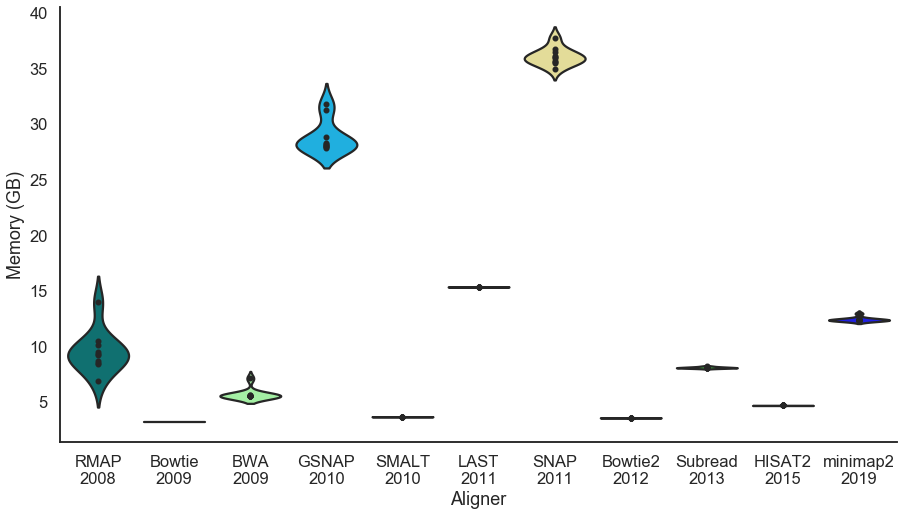

In [29]:
plt.figure(figsize=(15,8))

sns.set_style('white')
sns.set_context('talk')
ax = sns.violinplot(data = memyear_melt, x = 'aligner', y = 'memory', scale='width', palette=tool_clrs,# color="grey",
                    order=order_by_year, inner='points', alpha=.75)
ax.set(xlabel = 'Aligner', ylabel = 'Memory (GB)')
ax.set_xticklabels(#rotation=40, ha="right", 
                   labels=["RMAP\n2008", "Bowtie\n2009", "BWA\n2009", "GSNAP\n2010", "SMALT\n2010", "LAST\n2011", 
                           "SNAP\n2011", "Bowtie2\n2012", "Subread\n2013", "HISAT2\n2015", "minimap2\n2019"])

sns.despine()
#plt.show()
plt.savefig('../figures/Figure3_a_1.png')
plt.savefig('../figures/Figure3_a_1.pdf')

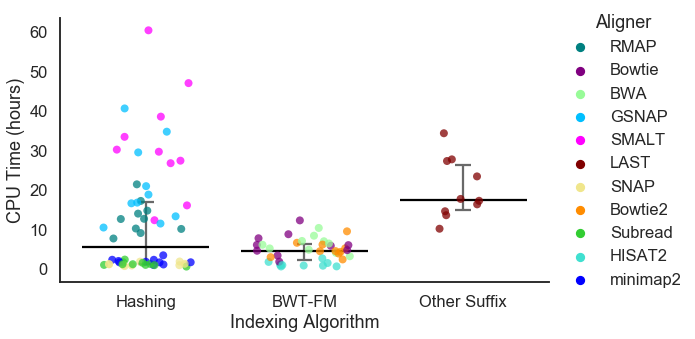

In [30]:
plt.figure(figsize=(10,5))

sns.set_style('white')
sns.set_context('talk')
#ax = sns.boxplot(data = rtyear_melt, x = 'index', y = 'runtime', whis=0,
#                 order=['Hashing','BWT-FM','Other Suffix'], color="1", fliersize=0)

medians = rtyear_melt.groupby('index').median()
upper = rtyear_melt.groupby('index').quantile(q=.75)
lower = rtyear_melt.groupby('index').quantile(q=.25)

ax = sns.stripplot(data = rtyear_melt, x = 'index', y = 'runtime',
                   order=['Hashing','BWT-FM','Other Suffix'], 
                   palette=tool_clrs, hue="aligner", hue_order=order_by_year, size=8, jitter=.3, alpha=.75)


plt.hlines(upper.loc[upper.index == 'Hashing','runtime'], -.05, .05, color="dimgray", linestyle='solid')
plt.hlines(lower.loc[lower.index == 'Hashing','runtime'], -.05, .05, color="dimgray", linestyle='solid')
plt.vlines(0, lower.loc[lower.index == 'Hashing','runtime'], upper.loc[upper.index == 'Hashing','runtime'], 
           color="dimgray", linestyle='solid')
plt.hlines(medians.loc[medians.index == 'Hashing','runtime'], -.4, .4, color="black", linestyle='solid')
plt.hlines(upper.loc[upper.index == 'BWT-FM','runtime'], .95, 1.05, color="dimgray", linestyle='solid')
plt.hlines(lower.loc[lower.index == 'BWT-FM','runtime'], .95, 1.05, color="dimgray", linestyle='solid')
plt.vlines(1, lower.loc[lower.index == 'BWT-FM','runtime'], upper.loc[upper.index == 'BWT-FM','runtime'], 
           color="dimgray", linestyle='solid')
plt.hlines(medians.loc[medians.index == 'BWT-FM','runtime'], 0.6, 1.4, color="black", linestyle='solid')
plt.hlines(upper.loc[upper.index == 'Other Suffix','runtime'], 1.95, 2.05, color="dimgray", linestyle='solid')
plt.hlines(lower.loc[lower.index == 'Other Suffix','runtime'], 1.95, 2.05, color="dimgray", linestyle='solid')
plt.vlines(2, lower.loc[lower.index == 'Other Suffix','runtime'], upper.loc[upper.index == 'Other Suffix','runtime'], 
           color="dimgray", linestyle='solid')
plt.hlines(medians.loc[medians.index == 'Other Suffix','runtime'], 1.6, 2.4, color="black", linestyle='solid')


ax.set(xlabel = 'Indexing Algorithm', ylabel = 'CPU Time (hours)')
leg = plt.legend(title='Aligner', loc='center left', bbox_to_anchor=(1, .5), frameon=False)

sns.despine()
plt.tight_layout()
# plt.show()
plt.savefig('../figures/Figure3_b_0.png')
plt.savefig('../figures/Figure3_b_0.pdf')

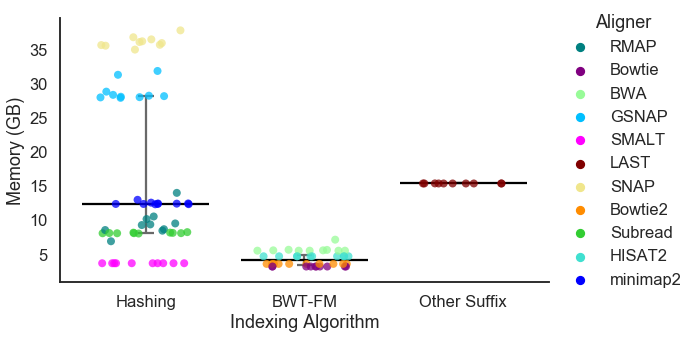

In [31]:
plt.figure(figsize=(10,5))

sns.set_style('white')
sns.set_context('talk')

medians = memyear_melt.groupby('index').median()
upper = memyear_melt.groupby('index').quantile(q=.75)
lower = memyear_melt.groupby('index').quantile(q=.25)

#ax = sns.boxplot(data = memyear_melt, x = 'index', y = 'memory', order=['Hashing','BWT-FM','Other Suffix'],
#                 color="1", fliersize=0, whis=0)
ax = sns.stripplot(data = memyear_melt, x = 'index', y = 'memory', order=['Hashing','BWT-FM','Other Suffix'],
                  palette=tool_clrs, hue="aligner", hue_order=order_by_year, size=8, jitter=.3, alpha=.75)

plt.hlines(upper.loc[upper.index == 'Hashing','memory'], -.05, .05, color="dimgray", linestyle='solid')
plt.hlines(lower.loc[lower.index == 'Hashing','memory'], -.05, .05, color="dimgray", linestyle='solid')
plt.vlines(0, lower.loc[lower.index == 'Hashing','memory'], upper.loc[upper.index == 'Hashing','memory'], 
           color="dimgray", linestyle='solid')
plt.hlines(medians.loc[medians.index == 'Hashing','memory'], -.4, .4, color="black", linestyle='solid')
plt.hlines(upper.loc[upper.index == 'BWT-FM','memory'], .95, 1.05, color="dimgray", linestyle='solid')
plt.hlines(lower.loc[lower.index == 'BWT-FM','memory'], .95, 1.05, color="dimgray", linestyle='solid')
plt.vlines(1, lower.loc[lower.index == 'BWT-FM','memory'], upper.loc[upper.index == 'BWT-FM','memory'], 
           color="dimgray", linestyle='solid')
plt.hlines(medians.loc[medians.index == 'BWT-FM','memory'], 0.6, 1.4, color="black", linestyle='solid')
plt.hlines(upper.loc[upper.index == 'Other Suffix','memory'], 1.95, 2.05, color="dimgray", linestyle='solid')
plt.hlines(lower.loc[lower.index == 'Other Suffix','memory'], 1.95, 2.05, color="dimgray", linestyle='solid')
plt.vlines(2, lower.loc[lower.index == 'Other Suffix','memory'], upper.loc[upper.index == 'Other Suffix','memory'], 
           color="dimgray", linestyle='solid')
plt.hlines(medians.loc[medians.index == 'Other Suffix','memory'], 1.6, 2.4, color="black", linestyle='solid')

ax.set(xlabel = 'Indexing Algorithm', ylabel = 'Memory (GB)')
leg = plt.legend(title='Aligner', loc='center left', bbox_to_anchor=(1, .5), frameon=False)
plt.tight_layout()
#plt.show()
sns.despine()

plt.savefig('../figures/Figure3_b_1.png')
plt.savefig('../figures/Figure3_b_1.pdf')

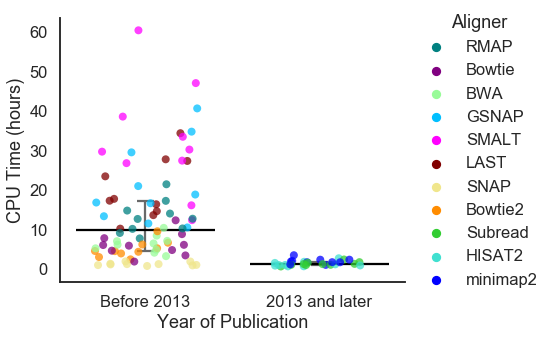

In [32]:
plt.figure(figsize=(8,5))

sns.set_style('white')
sns.set_context('talk')

medians = rtyear_melt.groupby('year_split').median()
upper = rtyear_melt.groupby('year_split').quantile(q=.75)
lower = rtyear_melt.groupby('year_split').quantile(q=.25)


# ax = sns.boxplot(data = rtyear_melt, x = 'year_split', y = 'runtime', whis=0,
#                  order = ['Before 2013', '2013 and later'], color="1", fliersize = 0)
ax = sns.stripplot(data= rtyear_melt, x = 'year_split', y = 'runtime', order=['Before 2013','2013 and later'],
                   palette=tool_clrs, hue="aligner", hue_order=order_by_year, size=8, jitter=.3, alpha=.75)

plt.hlines(upper.loc[upper.index == 'Before 2013','runtime'], -.05, .05, color="dimgray", linestyle='solid')
plt.hlines(lower.loc[lower.index == 'Before 2013','runtime'], -.05, .05, color="dimgray", linestyle='solid')
plt.vlines(0, lower.loc[lower.index == 'Before 2013','runtime'], upper.loc[upper.index == 'Before 2013','runtime'], 
           color="dimgray", linestyle='solid')
plt.hlines(medians.loc[medians.index == 'Before 2013','runtime'], -.4, .4, color="black", linestyle='solid')
plt.hlines(upper.loc[upper.index == '2013 and later','runtime'], .95, 1.05, color="dimgray", linestyle='solid')
plt.hlines(lower.loc[lower.index == '2013 and later','runtime'], .95, 1.05, color="dimgray", linestyle='solid')
plt.vlines(1, lower.loc[lower.index == '2013 and later','runtime'], upper.loc[upper.index == '2013 and later','runtime'], 
           color="dimgray", linestyle='solid')
plt.hlines(medians.loc[medians.index == '2013 and later','runtime'], 0.6, 1.4, color="black", linestyle='solid')

ax.set(xlabel = 'Year of Publication', ylabel = 'CPU Time (hours)')
leg = plt.legend(title='Aligner', loc='center left', bbox_to_anchor=(1, .5), frameon=False)
plt.tight_layout()
sns.despine()

#plt.show()
plt.savefig('../figures/Figure3_c_0.png')
plt.savefig('../figures/Figure3_c_0.pdf')

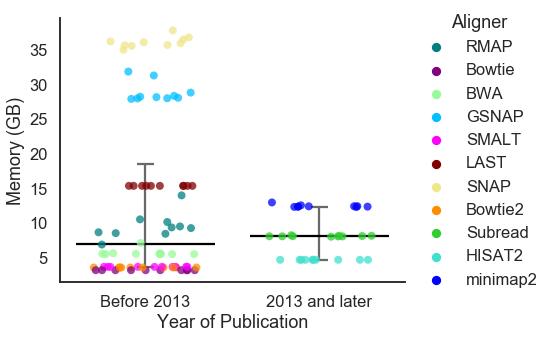

In [33]:
plt.figure(figsize=(8,5))

sns.set_style('white')
sns.set_context('talk')

medians = memyear_melt.groupby('year_split').median()
upper = memyear_melt.groupby('year_split').quantile(q=.75)
lower = memyear_melt.groupby('year_split').quantile(q=.25)

# ax = sns.boxplot(data = memyear_melt, x = 'year_split', y = 'memory', whis=0, fliersize=0,
#                  order = ['Before 2013', '2013 and later'], color="1")
ax = sns.stripplot(data = memyear_melt, x = 'year_split', y = 'memory', order=['Before 2013','2013 and later'],
                   palette=tool_clrs, hue="aligner", hue_order=order_by_year, size=8, jitter=.3, alpha=.75)

plt.hlines(upper.loc[upper.index == 'Before 2013','memory'], -.05, .05, color="dimgray", linestyle='solid')
plt.hlines(lower.loc[lower.index == 'Before 2013','memory'], -.05, .05, color="dimgray", linestyle='solid')
plt.vlines(0, lower.loc[lower.index == 'Before 2013','memory'], upper.loc[upper.index == 'Before 2013','memory'], 
           color="dimgray", linestyle='solid')
plt.hlines(medians.loc[medians.index == 'Before 2013','memory'], -.4, .4, color="black", linestyle='solid')
plt.hlines(upper.loc[upper.index == '2013 and later','memory'], .95, 1.05, color="dimgray", linestyle='solid')
plt.hlines(lower.loc[lower.index == '2013 and later','memory'], .95, 1.05, color="dimgray", linestyle='solid')
plt.vlines(1, lower.loc[lower.index == '2013 and later','memory'], upper.loc[upper.index == '2013 and later','memory'], 
           color="dimgray", linestyle='solid')
plt.hlines(medians.loc[medians.index == '2013 and later','memory'], 0.6, 1.4, color="black", linestyle='solid')

ax.set(xlabel = 'Year of Publication', ylabel = 'Memory (GB)')
leg = plt.legend(title='Aligner', loc='center left', bbox_to_anchor=(1, .5), frameon=False)
plt.tight_layout()
#plt.show()
sns.despine()

plt.savefig('../figures/Figure3_c_1.png')
plt.savefig('../figures/Figure3_c_1.pdf')

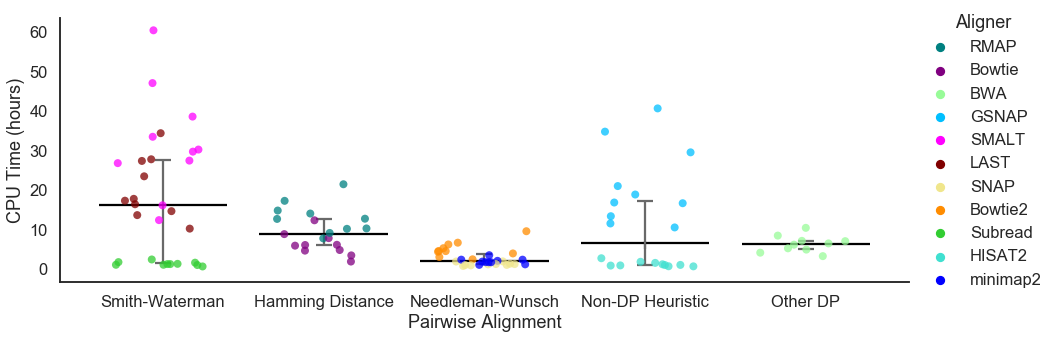

In [34]:
plt.figure(figsize=(15,5))

sns.set_style('white')
sns.set_context('talk')

medians = rtyear_melt.groupby('pairwise').median()
upper = rtyear_melt.groupby('pairwise').quantile(q=.75)
lower = rtyear_melt.groupby('pairwise').quantile(q=.25)


#ax = sns.boxplot(data = rtyear_melt, x = 'pairwise', y = 'runtime', 
#                 order=['Smith-Waterman','Hamming Distance','Needleman-Wunsch','Non-DP Heuristic'], 
#                 fliersize=0, color="1", whis=0)
ax = sns.stripplot(data = rtyear_melt, x = 'pairwise', y = 'runtime', 
                   order=['Smith-Waterman','Hamming Distance','Needleman-Wunsch','Non-DP Heuristic', 'Other DP'],
                   hue="aligner", hue_order=order_by_year, palette=tool_clrs, size=8, jitter=.3, alpha=.75)

plt.hlines(upper.loc[upper.index == 'Smith-Waterman','runtime'], -.05, .05, color="dimgray", linestyle='solid')
plt.hlines(lower.loc[lower.index == 'Smith-Waterman','runtime'], -.05, .05, color="dimgray", linestyle='solid')
plt.vlines(0, lower.loc[lower.index == 'Smith-Waterman','runtime'], upper.loc[upper.index == 'Smith-Waterman','runtime'], 
           color="dimgray", linestyle='solid')
plt.hlines(medians.loc[medians.index == 'Smith-Waterman','runtime'], -.4, .4, color="black", linestyle='solid')
plt.hlines(upper.loc[upper.index == 'Hamming Distance','runtime'], .95, 1.05, color="dimgray", linestyle='solid')
plt.hlines(lower.loc[lower.index == 'Hamming Distance','runtime'], .95, 1.05, color="dimgray", linestyle='solid')
plt.vlines(1, lower.loc[lower.index == 'Hamming Distance','runtime'], upper.loc[upper.index == 'Hamming Distance','runtime'], 
           color="dimgray", linestyle='solid')
plt.hlines(medians.loc[medians.index == 'Hamming Distance','runtime'], 0.6, 1.4, color="black", linestyle='solid')
plt.hlines(upper.loc[upper.index == 'Needleman-Wunsch','runtime'], 1.95, 2.05, color="dimgray", linestyle='solid')
plt.hlines(lower.loc[lower.index == 'Needleman-Wunsch','runtime'], 1.95, 2.05, color="dimgray", linestyle='solid')
plt.vlines(2, lower.loc[lower.index == 'Needleman-Wunsch','runtime'], upper.loc[upper.index == 'Needleman-Wunsch','runtime'], 
           color="dimgray", linestyle='solid')
plt.hlines(medians.loc[medians.index == 'Needleman-Wunsch','runtime'], 1.6, 2.4, color="black", linestyle='solid')
plt.hlines(upper.loc[upper.index == 'Non-DP Heuristic','runtime'], 2.95, 3.05, color="dimgray", linestyle='solid')
plt.hlines(lower.loc[lower.index == 'Non-DP Heuristic','runtime'], 2.95, 3.05, color="dimgray", linestyle='solid')
plt.vlines(3, lower.loc[lower.index == 'Non-DP Heuristic','runtime'], upper.loc[upper.index == 'Non-DP Heuristic','runtime'], 
           color="dimgray", linestyle='solid')
plt.hlines(medians.loc[medians.index == 'Non-DP Heuristic','runtime'], 2.6, 3.4, color="black", linestyle='solid')
plt.hlines(upper.loc[upper.index == 'Other DP','runtime'], 3.95, 4.05, color="dimgray", linestyle='solid')
plt.hlines(lower.loc[lower.index == 'Other DP','runtime'], 3.95, 4.05, color="dimgray", linestyle='solid')
plt.vlines(3, lower.loc[lower.index == 'Other DP','runtime'], upper.loc[upper.index == 'Other DP','runtime'], 
           color="dimgray", linestyle='solid')
plt.hlines(medians.loc[medians.index == 'Other DP','runtime'], 3.6, 4.4, color="black", linestyle='solid')

ax.set(xlabel = 'Pairwise Alignment', ylabel = 'CPU Time (hours)')
leg = plt.legend(title='Aligner', loc='center left', bbox_to_anchor=(1, .5), frameon=False)

plt.tight_layout()
#plt.show()
sns.despine()

plt.savefig('../figures/Figure3_d_0.png')
plt.savefig('../figures/Figure3_d_0.pdf')

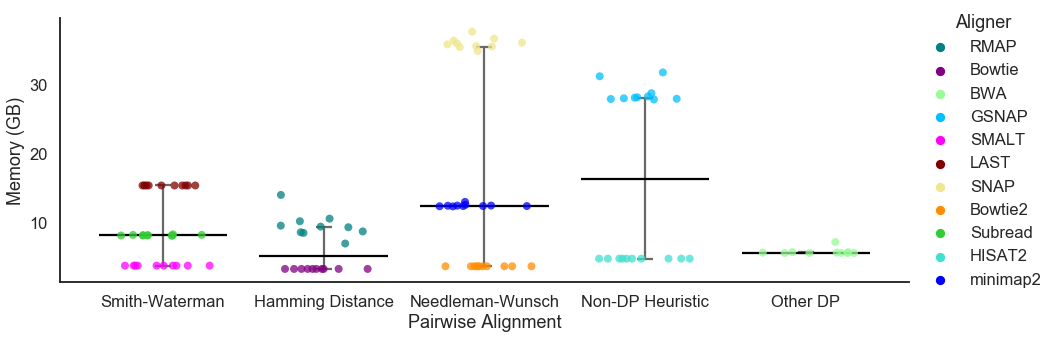

In [35]:
plt.figure(figsize=(15,5))

sns.set_style('white')
sns.set_context('talk')

medians = memyear_melt.groupby('pairwise').median()
upper = memyear_melt.groupby('pairwise').quantile(q=.75)
lower = memyear_melt.groupby('pairwise').quantile(q=.25)


#ax = sns.boxplot(data = memyear_melt, x = 'pairwise', y = 'memory',
#                 order=['Smith-Waterman','Hamming Distance','Needleman-Wunsch','Non-DP Heuristic'], 
#                 color="1", fliersize=0, whis=0) 
ax = sns.stripplot(data = memyear_melt, x = 'pairwise', y = 'memory', 
                   order=['Smith-Waterman','Hamming Distance','Needleman-Wunsch','Non-DP Heuristic', 'Other DP'],
                   hue="aligner", hue_order=order_by_year, palette=tool_clrs, size=8, jitter=.3, alpha=.75)

plt.hlines(upper.loc[upper.index == 'Smith-Waterman','memory'], -.05, .05, color="dimgray", linestyle='solid')
plt.hlines(lower.loc[lower.index == 'Smith-Waterman','memory'], -.05, .05, color="dimgray", linestyle='solid')
plt.vlines(0, lower.loc[lower.index == 'Smith-Waterman','memory'], upper.loc[upper.index == 'Smith-Waterman','memory'], 
           color="dimgray", linestyle='solid')
plt.hlines(medians.loc[medians.index == 'Smith-Waterman','memory'], -.4, .4, color="black", linestyle='solid')
plt.hlines(upper.loc[upper.index == 'Hamming Distance','memory'], .95, 1.05, color="dimgray", linestyle='solid')
plt.hlines(lower.loc[lower.index == 'Hamming Distance','memory'], .95, 1.05, color="dimgray", linestyle='solid')
plt.vlines(1, lower.loc[lower.index == 'Hamming Distance','memory'], upper.loc[upper.index == 'Hamming Distance','memory'], 
           color="dimgray", linestyle='solid')
plt.hlines(medians.loc[medians.index == 'Hamming Distance','memory'], 0.6, 1.4, color="black", linestyle='solid')
plt.hlines(upper.loc[upper.index == 'Needleman-Wunsch','memory'], 1.95, 2.05, color="dimgray", linestyle='solid')
plt.hlines(lower.loc[lower.index == 'Needleman-Wunsch','memory'], 1.95, 2.05, color="dimgray", linestyle='solid')
plt.vlines(2, lower.loc[lower.index == 'Needleman-Wunsch','memory'], upper.loc[upper.index == 'Needleman-Wunsch','memory'], 
           color="dimgray", linestyle='solid')
plt.hlines(medians.loc[medians.index == 'Needleman-Wunsch','memory'], 1.6, 2.4, color="black", linestyle='solid')
plt.hlines(upper.loc[upper.index == 'Non-DP Heuristic','memory'], 2.95, 3.05, color="dimgray", linestyle='solid')
plt.hlines(lower.loc[lower.index == 'Non-DP Heuristic','memory'], 2.95, 3.05, color="dimgray", linestyle='solid')
plt.vlines(3, lower.loc[lower.index == 'Non-DP Heuristic','memory'], upper.loc[upper.index == 'Non-DP Heuristic','memory'], 
           color="dimgray", linestyle='solid')
plt.hlines(medians.loc[medians.index == 'Non-DP Heuristic','memory'], 2.6, 3.4, color="black", linestyle='solid')
plt.hlines(upper.loc[upper.index == 'Other DP','memory'], 3.95, 4.05, color="dimgray", linestyle='solid')
plt.hlines(lower.loc[lower.index == 'Other DP','memory'], 3.95, 4.05, color="dimgray", linestyle='solid')
plt.vlines(3, lower.loc[lower.index == 'Other DP','memory'], upper.loc[upper.index == 'Other DP','memory'], 
           color="dimgray", linestyle='solid')
plt.hlines(medians.loc[medians.index == 'Other DP','memory'], 3.6, 4.4, color="black", linestyle='solid')

ax.set(xlabel = 'Pairwise Alignment', ylabel = 'Memory (GB)')
leg = plt.legend(title='Aligner', loc='center left', bbox_to_anchor=(1, .5), frameon=False)
plt.tight_layout()
#plt.show()
sns.despine()

plt.savefig('../figures/Figure3_d_1.png')
plt.savefig('../figures/Figure3_d_1.pdf')